In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch.optim as optim
import torch.utils.data as data
from tqdm import trange
from tqdm import tqdm
try:
    torch.set_default_tensor_type('torch.cuda.FloatTensor')  # enable for GPU
except:
    pass

In [2]:
class FCNN(nn.Module):
    """
    Simple fully connected neural network.
    """
    def __init__(self, in_dim, out_dim, hidden_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.Tanh(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x):
        return self.network(x)
    
# def setup_seed(seed):
#       torch.manual_seed(seed)
#       torch.cuda.manual_seed_all(seed)
#       np.random.seed(seed)
#       # random.seed(seed)
#       torch.backends.cudnn.deterministic = True

In [3]:
mu, sigma=0,1
N_samples = 1000000 # 1e6 is fine
batch_Size = 10000
x_rep=1 ## to generate X_t from same X_0 for $x_rep paths

Nt=200
T=10
tls=np.linspace(0,1,Nt)
# t = t**2 * T
t_fw=T*tls**1
# t_test=T*tls**2 # quadradic schedule

# exponential schedule
t1 = 1e-4
alpha_t = np.log(T/t1)*(1/(Nt-1))
t_test = np.zeros([Nt+1,])
t_test[1:] = t1*np.exp(alpha_t*np.arange(0,Nt,1))

# data type: 0 bivariate normal; 1 single line normal; 2 uniform * normal; 3 Correlated line
data_type=6

## method == 1 for f to S (CEM); method == 2 for S (SGM); method == 3 for epsilon to S (DDPM); 
method = 1
N_test=10000

In [4]:
# setup_seed(12) 
tis1 = time.perf_counter()
iterations = 200
dim_ip = 3
dim_op = 2
hidden_dim = 32


In [5]:
def gen_dat(mu,sigma,N_samples,data_type):
    x1_data = mu + sigma * np.random.randn(N_samples)
    if data_type==0:
        x2_data = mu + sigma * np.random.randn(N_samples)
    if data_type==1:
        x2_data = 0*np.ones(x1_data.shape)
        # x2_data = x1_data
    if data_type==2:
        # x1_data = mu + sigma * (np.random.uniform(size=N_samples)-0.5)
        x2_data = (np.random.uniform(size=N_samples)-0.5)*2
    if data_type==3:
        # x1_data = mu + sigma * (np.random.uniform(size=N_samples)-0.5)
        x2_data = x1_data**2
    if data_type==4:
        x1_data = (np.random.uniform(size=N_samples)-0.5)*2*sigma+mu
        x2_data = (np.random.uniform(size=N_samples)-0.5)*2
    if data_type==5:
        U = (np.random.uniform(size=N_samples))*12+1
        x1_data = U * np.cos(U)
        x2_data = U * np.sin(U)
    if data_type==6:
        x1_data = 1 + 0 * np.random.randn(N_samples)
        x1_data[N_samples//2:] -= 2
        x2_data = -1 + 0 * np.random.randn(N_samples)
        x2_data[N_samples//2:] += 2
    if data_type==7:
        x1_data = 1 + 0 * np.random.randn(N_samples)
        x2_data = -1 + 0 * np.random.randn(N_samples)
    if data_type==8:
        x1_data = 1 + 0 * np.random.randn(N_samples)
#         x1_data[N_samples//2:] -= 2
        x2_data = -1 + 0 * np.random.randn(N_samples)
        x2_data[N_samples//4:N_samples//2] += 2
        x2_data[N_samples//2:3*N_samples//4] += 4
        x2_data[3*N_samples//4:] -= 2
    if data_type==9:
        U = (np.random.uniform(size=N_samples))*12+1
        x1_data = U * np.cos(U)
        x2_data = U * np.sin(U)
    if data_type==10:
        U = (np.random.uniform(size=N_samples))*12+1
        x1_data = U * np.cos(U)
        x2_data = U * np.sin(U)
    if data_type==11:
        x1_data = 1 + 0 * np.random.randn(N_samples)
#         x1_data[N_samples//2:] -= 2
        x2_data = -1 + 0 * np.random.randn(N_samples)
        x2_data[N_samples//5:2*N_samples//5] += 2
        x2_data[2*N_samples//5:3*N_samples//5] += 4
        x2_data[3*N_samples//5:4*N_samples//5] -= 2
        x2_data[4*N_samples//5:] -= 4
    return x1_data,x2_data
x1_data,x2_data=gen_dat(mu,sigma,N_samples,data_type)
t_data = np.random.choice(t_fw[1:],(N_samples,))
## time
t_tf = torch.Tensor(t_data.reshape(-1,1))
## samples come from P_data
x1_tf = torch.Tensor(x1_data.reshape(-1,1))
x2_tf = torch.Tensor(x2_data.reshape(-1,1))

## cat([X0, N], dim=1)
init_data = torch.cat([x1_tf, x2_tf, t_tf],dim=1)



loader = data.DataLoader(
dataset = init_data,
batch_size=batch_Size,             
shuffle=True,  
# generator=torch.Generator(device='cuda'),          
)

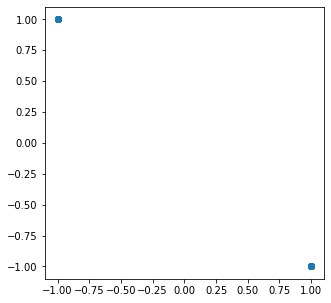

In [6]:
plt.figure(figsize=(5,5))
plt.scatter(x1_data, x2_data)

In [7]:
model = FCNN(dim_ip, dim_op, hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# def func(arr):
#     x1 = arr[0]
#     x2 = arr[1]
#     t_est = arr[2]
#     mu, sigma=0,1
#     N_samples = 10000
#     data_type=5
#     x1_data,x2_data=gen_dat(mu,sigma,N_samples,data_type)
# #     print(x1_data.size)
#     w=np.exp(-((x1-x1_data*np.exp(-t_est/2))**2+(x2-x2_data*np.exp(-t_est/2))**2)/(2*(1-np.exp(-t_est))))
#     Ex01=np.sum(x1_data*w)/(np.sum(w))
#     Ex02=np.sum(x2_data*w)/(np.sum(w))
#     return Ex01, Ex02
# nx_eval=10000
# x1_eval,x2_eval=gen_dat(mu,sigma,nx_eval,data_type)
# t_eval=t_test[5:]
# nt_eval=len(t_eval)
# x1 =np.concatenate((x1_eval.reshape(-1,1),x2_eval.reshape(-1,1)),axis=1)
# lambda_eval=np.zeros(nt_eval)
# for i in range(nt_eval):
#     normal_samples = np.random.randn(nx_eval,2)
#     y_batch = x1*np.exp(-t_eval[i]/2) + np.sqrt(1-np.exp(-t_eval[i]))*normal_samples
#     arr = np.concatenate((y_batch, t_eval[i]*np.ones([nx_eval,1])),axis=1)
#     Ex0= np.array(list(map(func, arr)))
# #     lambda_eval[i]=np.mean((x1-Ex0)**2)
#     drift_back1 = Ex0[:, 0]
#     drift_back2 = Ex0[:, 1]
# #     print(drift_back1.shape)
#     lambda_eval[i]=np.mean((x1_eval-drift_back1)**2 + (x2_eval-drift_back2)**2)


# lambda_guess=np.exp(t_eval)-1
# # lambda_guess=1-np.exp(-t_eval)
# plt.plot(t_eval,lambda_guess,'+-')
# # plt.show()
# plt.plot(t_eval,lambda_eval,'r+-')
# plt.show()

KeyboardInterrupt: 

In [ ]:
# lambda_guess=np.exp(t_eval)-1
# plt.figure(dpi=64, figsize=(3,2))
# plt.plot(t_eval[:150],lambda_guess[:150],'r-.',label='guess')
# # plt.show()
# plt.plot(t_eval[:150],lambda_eval[:150],'b--',label='true')
# plt.xlabel('t')
# plt.ylabel('$1/\lambda$')
# plt.legend()
# # plt.show()
# fig = plt.gcf()
# fig.savefig('./lambda_fitted.eps', bbox_inches = 'tight')

In [ ]:

Loss = np.array([])
# for epoch in range(iterations):    
pbar = trange(iterations)
for epoch in pbar: 
    for step, batch_x in enumerate(loader):
        optimizer.zero_grad()
        x_tf_batch = batch_x[:,0:2].repeat((x_rep,1))
#         t_tf_batch = (T*torch.rand([batch_Size, 1])**2).repeat((x_rep,1))
        t_tf_batch = batch_x[torch.randperm(batch_Size),2:3].repeat((x_rep,1))
        normal_samples_tf = torch.randn(batch_Size*x_rep,2)
        y_tf_batch = x_tf_batch*torch.exp(-t_tf_batch/2) + torch.sqrt(1-torch.exp(-t_tf_batch))*normal_samples_tf
        NN_input = torch.cat([y_tf_batch, t_tf_batch], dim=1)
        
        s = (model(NN_input))
        if method == 1:
#             lambda_func = 1/(torch.exp(t_tf_batch)-1)**2
            lambda_func = 1/(torch.exp(t_tf_batch)-1)
#             lambda_func = 1
            loss = torch.mean(lambda_func*(x_tf_batch- s)**2) ## +normal_samples_tf2*torch.sqrt(1-torch.exp(-t_tf_batch))
        elif method == 2:
            loss = torch.mean((normal_samples_tf/torch.sqrt(1-torch.exp(-t_tf_batch))-s)**2*(1-torch.exp(-t_tf_batch))) # S, lambda(t)=1-exp(-t)
        elif method == 3:
            loss = torch.mean((normal_samples_tf-s)**2) ## epsilon, lambda(t)=1-exp(-t)
        loss.backward()
        optimizer.step()
        tmp = loss.cpu().detach().numpy()
    Loss = np.append(Loss, tmp)
    pbar.set_postfix({'Loss': tmp})
    
## Plotting the loss function
q=np.arange(0,len(Loss))
plt.plot(q,Loss,'r')
plt.show()

tis2 = time.perf_counter()
print("Time used:", tis2-tis1)

In [ ]:
# Nt = 50
# t_test=T*np.linspace(0,1,Nt+1)**1 # quadradic schedule

# # exponential schedule
# t1 = 1e-4
# alpha_t = np.log(T/t1)*(1/(Nt-1))
# t_test = np.zeros([Nt+1,])
# t_test[1:] = t1*np.exp(alpha_t*np.arange(0,Nt,1))

x1 = np.random.randn(N_test).reshape(-1,1)
x2 = np.random.randn(N_test).reshape(-1,1)
x = np.concatenate((x1,x2),axis=1)
## reverse SDE
t_tf = torch.Tensor(t_test.reshape(-1,1))
for i in range(Nt-0):
    dt = t_test[-i-1]-t_test[-i-2]
    alpha = np.exp(-dt)
    alpha_bar = np.exp(-t_test[-i-1])
    t1_tf_repeat = t_tf[-i-1].repeat(N_test).reshape(-1,1)
    drift_back = model(torch.cat([torch.Tensor(x), t1_tf_repeat],dim=1)).cpu().detach().numpy()
    if method == 1:
        # drift_back=np.sqrt(alpha_bar)*np.concatenate((x[:,0:1],np.zeros((N_test,1))),axis=1) # this is what we expect to learn
        
        # Classic
        
        # x0 = (x - dt*(x/(1-alpha_bar) - np.sqrt(alpha_bar)*drift_back/(1-alpha_bar)))/np.sqrt(alpha) + np.sqrt(1-alpha)*np.random.randn(N_test,2) # f
        
        # Scheme 1
        
        # # drift_back=np.clip(drift_back,-1,1)
        
        dw=np.sqrt(1-alpha)*np.random.randn(N_test,2)
#         x0 = (x - dt*(x/(1-alpha_bar) - np.sqrt(alpha_bar)*drift_back/(1-alpha_bar)))*np.sqrt(alpha) + dw # f
        x0 = (x - dt*(x*alpha_bar/(1-alpha_bar) - np.sqrt(alpha_bar)*drift_back/(1-alpha_bar)))*np.sqrt(alpha) + dw # f
        
    elif method == 2:
        x0 = (x - dt*drift_back)*np.exp(dt/2) + np.sqrt(1-alpha)*np.random.randn(N_test,2) # S
    elif method == 3:
        x0 = (x - dt*drift_back/np.sqrt(1-alpha_bar))/np.sqrt(alpha) + np.sqrt(1-alpha)*np.random.randn(N_test,2) #epsilon
    x = x0
    

In [ ]:
## scatter plot
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.scatter(x[:,0], x[:,1])
plt.xlim([-15,15])
plt.ylim([-15,15])
plt.subplot(1,2,2)
plt.scatter(x1_data, x2_data)
plt.xlim([-15,15])
plt.ylim([-15,15])
plt.show()
# fig = plt.gcf()
# fig.savefig('./curve.png')

In [ ]:
## x1
plt.figure()
ax1=plt.subplot(1,2,1)
ax1.hist(x[:,0],bins=50,range=(-4,4))
# ax1.set_xlim([-5,5])
ax2=plt.subplot(1,2,2)
ax2.hist(x1_data,bins=50,range=(-4,4))
# ax2.set_xlim([-5,5])
plt.show()
print('Mean_estimated=',np.mean(x[:,0]),'\n''Var_estimated=',np.var(x[:,0]))
print('Mean_true=',np.mean(x1_data),'\n''Var_true=',np.var(x1_data))

In [ ]:
## x1
plt.figure()
ax1=plt.subplot(1,2,1)
ax1.hist(x[:,1],bins=50)
# ax1.set_xlim([0,10])
ax2=plt.subplot(1,2,2)
ax2.hist(x2_data,bins=50)
# ax2.set_xlim([0,10])
plt.show()
print('Mean_estimated=',np.mean(x[:,1]),'\n''Var_estimated=',np.var(x[:,1]))
print('Mean_true=',np.mean(x2_data),'\n''Var_true=',np.var(x2_data))

In [ ]:
# if data_type == 0:
#     if method == 1:
#         np.save("binormal_"+"new_score.npy",x)
#         np.save("binormal_"+"new_score_x1_data.npy",x1_data)
#         np.save("binormal_"+"new_score_x2_data.npy",x2_data)
#     if method == 2:
#         np.save("binormal_"+"score.npy",x)
#         np.save("binormal_"+"score_x1_data.npy",x1_data)
#         np.save("binormal_"+"score_x2_data.npy",x2_data)
#     if method == 3:
#         np.save("binormal_"+"ddpm.npy",x)
#         np.save("binormal_"+"ddpm_x1_data.npy",x1_data)
#         np.save("binormal_"+"ddpm_x2_data.npy",x2_data)
# if data_type == 1:
#     if method == 1:
#         np.save("line_normal_"+"new_score.npy",x)
#         np.save("line_normal_"+"new_score_x1_data.npy",x1_data)
#         np.save("line_normal_"+"new_score_x2_data.npy",x2_data)
#     if method == 2:
#         np.save("line_normal_"+"score.npy",x)
#         np.save("line_normal_"+"score_x1_data.npy",x1_data)
#         np.save("line_normal_"+"score_x2_data.npy",x2_data)
#     if method == 3:
#         np.save("line_normal_"+"ddpm.npy",x)
#         np.save("line_normal_"+"ddpm_x1_data.npy",x1_data)
#         np.save("line_normal_"+"ddpm_x2_data.npy",x2_data)

# if data_type == 2:
#     if method == 1:
#         np.save("uni_normal_"+"new_score.npy",x)
#         np.save("uni_normal_"+"new_score_x1_data.npy",x1_data)
#         np.save("uni_normal_"+"new_score_x2_data.npy",x2_data)
#     if method == 2:
#         np.save("uni_normal_"+"score.npy",x)
#         np.save("uni_normal_"+"score_x1_data.npy",x1_data)
#         np.save("uni_normal_"+"score_x2_data.npy",x2_data)
#     if method == 3:
#         np.save("uni_normal_"+"ddpm.npy",x)
#         np.save("uni_normal_"+"ddpm_x1_data.npy",x1_data)
#         np.save("uni_normal_"+"ddpm_x2_data.npy",x2_data)
        
# if data_type == 3:
#     if method == 1:
#         np.save("corr_normal_"+"new_score.npy",x)
#         np.save("corr_normal_"+"new_score_x1_data.npy",x1_data)
#         np.save("corr_normal_"+"new_score_x2_data.npy",x2_data)
#     if method == 2:
#         np.save("corr_normal_"+"score.npy",x)
#         np.save("corr_normal_"+"score_x1_data.npy",x1_data)
#         np.save("corr_normal_"+"score_x2_data.npy",x2_data)
#     if method == 3:
#         np.save("corr_normal_"+"ddpm.npy",x)
#         np.save("corr_normal_"+"ddpm_x1_data.npy",x1_data)
#         np.save("corr_normal_"+"ddpm_x2_data.npy",x2_data)
        
# if data_type == 4:
#     if method == 1:
#         np.save("biuni_"+"new_score.npy",x)
#         np.save("biuni_"+"new_score_x1_data.npy",x1_data)
#         np.save("biuni_"+"new_score_x2_data.npy",x2_data)
#     if method == 2:
#         np.save("biuni_"+"score.npy",x)
#         np.save("biuni_"+"score_x1_data.npy",x1_data)
#         np.save("biuni_"+"score_x2_data.npy",x2_data)
#     if method == 3:
#         np.save("biuni_"+"ddpm.npy",x)
#         np.save("biuni_"+"ddpm_x1_data.npy",x1_data)
#         np.save("biuni_"+"ddpm_x2_data.npy",x2_data)

# if data_type == 5:
#     if method == 1:
#         np.save("curve_"+"new_score.npy",x)
#         np.save("curve_"+"new_score_x1_data.npy",x1_data)
#         np.save("curve_"+"new_score_x2_data.npy",x2_data)
#     if method == 2:
#         np.save("curve_"+"score.npy",x)
#         np.save("curve_"+"score_x1_data.npy",x1_data)
#         np.save("curve_"+"score_x2_data.npy",x2_data)
#     if method == 3:
#         np.save("curve_"+"ddpm.npy",x)
#         np.save("curve_"+"ddpm_x1_data.npy",x1_data)
#         np.save("curve_"+"ddpm_x2_data.npy",x2_data)

# if data_type == 6:
#     if method == 1:
#         np.save("twoPoint_"+"new_score.npy",x)
#         np.save("twoPoint_"+"new_score_x1_data.npy",x1_data)
#         np.save("twoPoint_"+"new_score_x2_data.npy",x2_data)
#     if method == 2:
#         np.save("twoPoint_"+"score.npy",x)
#         np.save("twoPoint_"+"score_x1_data.npy",x1_data)
#         np.save("twoPoint_"+"score_x2_data.npy",x2_data)
#     if method == 3:
#         np.save("twoPoint_"+"ddpm.npy",x)
#         np.save("twoPoint_"+"ddpm_x1_data.npy",x1_data)
#         np.save("twoPoint_"+"ddpm_x2_data.npy",x2_data)

# if data_type == 8:
#     if method == 1:
#         np.save("fourPoints_"+"new_score_shallow.npy",x)
#         np.save("fourPoints_"+"new_score_x1_data_shallow.npy",x1_data)
#         np.save("fourPoints_"+"new_score_x2_data_shallow.npy",x2_data)
        
# if data_type == 9:
#     if method == 1:
#         np.save("curve_"+"new_score_shallow.npy",x)
#         np.save("curve_"+"new_score_x1_data_shallow.npy",x1_data)
#         np.save("curve_"+"new_score_x2_data_shallow.npy",x2_data)
# if data_type == 10:
#     if method == 1:
#         np.save("curve_"+"new_score_lambda.npy",x)
#         np.save("curve_"+"new_score_x1_data_lambda.npy",x1_data)
#         np.save("curve_"+"new_score_x2_data_lambda.npy",x2_data)


In [ ]:
# Nx1 = 101
# Nx2 = Nx1
# B1 = 0
# B2 = -0.1
# dx1 = 2*B1/Nx1
# dx2 = 2*B2/Nx2
# x1 = np.linspace(B1-2,B1+2,Nx1,endpoint=True)
# x2 = np.linspace(B2,B2+0.2,Nx2,endpoint=True)
# # x1 = np.linspace(-B1,B1,Nx1,endpoint=True)
# # x2 = np.linspace(-B2,B2,Nx2,endpoint=True)
# x1_grid, x2_grid = np.meshgrid(x1,x2)
# t_est = 0.001
# t_grid = t_est*np.ones(x1_grid.shape)
# x1_ip = x1_grid.reshape(-1,1)
# x2_ip = x2_grid.reshape(-1,1)
# t_ip = t_grid.reshape(-1,1)
# x1_ip_tf = torch.Tensor(x1_ip)
# x2_ip_tf = torch.Tensor(x2_ip)
# t_ip_tf = torch.Tensor(t_ip)
# drift_back_grid = model(torch.cat([x1_ip_tf, x2_ip_tf, t_ip_tf],dim=1)).cpu().detach().numpy()
# drift_back_grid1 = drift_back_grid[:,0].reshape(x1_grid.shape)
# drift_back_grid2 = drift_back_grid[:,1].reshape(x2_grid.shape)


In [ ]:
# if method ==1:
#     ## new score
#     # drift1_learned = (x1_grid - np.exp(-t_est/2)*(drift_back_grid1))/(1-np.exp(-t_est))-x1_grid/2
#     # drift2_learned = x2_grid/(1-np.exp(-t_est)) - np.exp(-t_est/2)*(drift_back_grid2)/(1-np.exp(-t_est))-x2_grid/2
#     drift1_learned = (drift_back_grid1)
#     drift2_learned = (drift_back_grid2)
# if method == 2:
#     ##score
#     drift1_learned = (drift_back_grid1)
#     drift2_learned = (drift_back_grid2)
# if method == 3:
#     # ##DDPM
#     # drift1_learned = (drift_back_grid1/np.sqrt(1-np.exp(-t_grid)))
#     # drift2_learned = (drift_back_grid2/np.sqrt(1-np.exp(-t_grid)))
#     drift1_learned = (drift_back_grid1)
#     drift2_learned = (drift_back_grid2)

# if data_type == 1:
#     # drift1_true = x1_grid-x1_grid/2
#     # drift2_true = x2_grid/(1-np.exp(-t_est))-x2_grid/2
#     drift1_true0=np.exp(-t_est/2)*x1_grid
#     drift2_true0=x1_grid*0
#     if method == 1:
#         drift1_true=drift1_true0
#         drift2_true=drift2_true0
#     if method == 2:
#         drift1_true=(x1_grid - np.exp(-t_est/2)*(drift1_true0))/(1-np.exp(-t_est))
#         drift2_true=(x2_grid - np.exp(-t_est/2)*(drift2_true0))/(1-np.exp(-t_est))
#     if method ==3:
#         drift1_true=(x1_grid - np.exp(-t_est/2)*(drift1_true0))/np.sqrt(1-np.exp(-t_est))
#         drift2_true=(x2_grid - np.exp(-t_est/2)*(drift2_true0))/np.sqrt(1-np.exp(-t_est))
    
# if data_type == 6:
#     tmp1 = np.exp(-((x1_grid-np.exp(-t_est/2))**2 + (x2_grid+np.exp(-t_est/2))**2) / (2*(1-np.exp(-t_est))))
#     tmp2 = np.exp(-((x1_grid+np.exp(-t_est/2))**2 + (x2_grid-np.exp(-t_est/2))**2) / (2*(1-np.exp(-t_est))))
#     drift1_true = (tmp1*(x1_grid-np.exp(-t_est/2))/(1-np.exp(-t_est)) + tmp2*((x1_grid+np.exp(-t_est/2)))/(1-np.exp(-t_est))) / (tmp1+tmp2)
#     drift2_true = (tmp1*(x2_grid+np.exp(-t_est/2))/(1-np.exp(-t_est)) + tmp2*((x2_grid-np.exp(-t_est/2)))/(1-np.exp(-t_est))) / (tmp1+tmp2)
# if data_type == 7:
#     drift1_true = (x1_grid-np.exp(-t_est/2))/(1-np.exp(-t_est))
#     drift2_true = (x2_grid+np.exp(-t_est/2))/(1-np.exp(-t_est))
    
# Accu1 = np.abs(drift1_learned - drift1_true)
# Accu2 = np.abs(drift2_learned-drift2_true)

# import seaborn as sns
# fig= plt.figure(figsize=(10,5))
# plt.subplot(2,3,1)
# sns.heatmap(drift1_learned, cmap='viridis')
# plt.xticks([])
# plt.yticks([])
# plt.title('Learned')
# plt.subplot(2,3,2)
# sns.heatmap(drift1_true, cmap='viridis')
# plt.xticks([])
# plt.yticks([])
# plt.title('True')
# plt.subplot(2,3,3)
# sns.heatmap(Accu1, cmap='viridis')
# plt.xticks([])
# plt.yticks([])
# plt.title('Error')
# plt.subplot(2,3,4)
# sns.heatmap(drift2_learned, cmap='viridis')
# plt.xticks([])
# plt.yticks([])
# # plt.title('Error')
# plt.subplot(2,3,5)
# sns.heatmap(drift2_true, cmap='viridis')
# plt.xticks([])
# plt.yticks([])
# # plt.title('${Drift}_1$')
# plt.subplot(2,3,6)
# sns.heatmap(Accu2, cmap='viridis')
# plt.xticks([])
# plt.yticks([])
# # plt.title('${Drift}_2$')



In [ ]:
# N_samples = 200000
# if data_type == 1:
#     x1_data = mu + sigma * np.random.randn(N_samples)
#     x2_data =0 * np.ones(N_samples)
# if data_type == 6:
#     x1_data = 1 + 0 * np.random.randn(N_samples)
#     x1_data[N_samples//2:] -= 2
#     x2_data = -1 + 0 * np.random.randn(N_samples)
#     x2_data[N_samples//2:] += 2
# Nt = 200
# # t_est_grid = np.array([0.001,0.005,0.01,0.05,0.2,0.3])
# t_est_grid = t_test[0:Nt]
# Accu_S1 = np.zeros(Nt)
# Accu_S2 = np.zeros(Nt)
# for i in range(Nt):
#     t_est = t_est_grid[i]
#     x1_t = x1_data*np.exp(-t_est/2)+np.sqrt(1-np.exp(-t_est))*np.random.randn(N_samples)
#     x2_t = x2_data*np.exp(-t_est/2)+np.sqrt(1-np.exp(-t_est))*np.random.randn(N_samples)

#     t_grid = t_est*np.ones(N_samples)
#     x1_ip = x1_t.reshape(-1,1)
#     x2_ip = x2_t.reshape(-1,1)
#     t_ip = t_grid.reshape(-1,1)
#     x1_ip_tf = torch.Tensor(x1_ip)
#     x2_ip_tf = torch.Tensor(x2_ip)
#     t_ip_tf = torch.Tensor(t_ip)
#     drift_back_eva = model(torch.cat([x1_ip_tf, x2_ip_tf, t_ip_tf],dim=1)).cpu().detach().numpy()
#     drift_back_eva1 = drift_back_eva[:,0]
#     drift_back_eva2 = drift_back_eva[:,1]
#     drift1_learned = drift_back_eva1
#     drift2_learned = drift_back_eva2
# #     if method == 1:
# #         ## new score
# # #         drift1_learned = x1_t/(1-np.exp(-t_est)) - np.exp(-t_est/2)*(drift_back_eva1)/(1-np.exp(-t_est))
# # #         drift2_learned = x2_t/(1-np.exp(-t_est)) - np.exp(-t_est/2)*(drift_back_eva2)/(1-np.exp(-t_est))
# #         drift1_learned = drift_back_eva1
# #         drift2_learned = drift_back_eva2
# #     if method == 2:
# #         ## score
# # #         drift1_learned = drift_back_eva1
# # #         drift2_learned = drift_back_eva2
# #         drift1_learned = np.exp(t_est/2) * (x1_t-(1-np.exp(-t_est)))*drift_back_eva1
# #         drift2_learned = np.exp(t_est/2) * (x2_t-(1-np.exp(-t_est)))*drift_back_eva2
# #     if method == 3:
# #         ## DDPM
# # #         drift1_learned = (drift_back_eva1/np.sqrt(1-np.exp(-t_grid)))
# # #         drift2_learned = (drift_back_eva2/np.sqrt(1-np.exp(-t_grid)))
# #         drift1_learned = np.exp(t_est/2) * (x1_t-np.sqrt(1-np.exp(-t_est)))*drift_back_eva1
# #         drift2_learned = np.exp(t_est/2) * (x2_t-np.sqrt(1-np.exp(-t_est)))*drift_back_eva2
    
#     if data_type==1:
# #         drift1_true = x1_t
# #         drift2_true = x2_t/(1-np.exp(-t_est))
# #         Ex01_true =  x1_t*np.exp(-t_est/2)
# #         Ex02_true = 0*x2_t
        
#         drift1_true0=np.exp(-t_est/2)*x1_t
#         drift2_true0=x2_t*0
#         if method == 1:
#             drift1_true=drift1_true0
#             drift2_true=drift2_true0
#         if method == 2:
#             drift1_true=(x1_t - np.exp(-t_est/2)*(drift1_true0))/(1-np.exp(-t_est))
#             drift2_true=(x2_t - np.exp(-t_est/2)*(drift2_true0))/(1-np.exp(-t_est))
#         if method ==3:
#             drift1_true=(x1_t - np.exp(-t_est/2)*(drift1_true0))/np.sqrt(1-np.exp(-t_est))
#             drift2_true=(x2_t - np.exp(-t_est/2)*(drift2_true0))/np.sqrt(1-np.exp(-t_est))
    
# #     if data_type==6:
# #         tmp1 = np.exp(-((x1_t-np.exp(-t_est/2))**2 + (x2_t+np.exp(-t_est/2))**2) / (2*(1-np.exp(-t_est))))
# #         tmp2 = np.exp(-((x1_t+np.exp(-t_est/2))**2 + (x2_t-np.exp(-t_est/2))**2) / (2*(1-np.exp(-t_est))))
# #         drift1_true = (tmp1*(x1_t-np.exp(-t_est/2))/(1-np.exp(-t_est)) + tmp2*((x1_t+np.exp(-t_est/2)))/(1-np.exp(-t_est))) / (tmp1+tmp2)
# #         drift2_true = (tmp1*(x2_t+np.exp(-t_est/2))/(1-np.exp(-t_est)) + tmp2*((x2_t-np.exp(-t_est/2)))/(1-np.exp(-t_est))) / (tmp1+tmp2)

# #     if data_type==7:
# #         drift1_true = (x1_t-np.exp(-t_est/2))/(1-np.exp(-t_est))
# #         drift2_true = ((x2_t+np.exp(-t_est/2)))/(1-np.exp(-t_est))

# #     Accu_S1[i] = np.mean((drift1_learned-drift1_true)**2)
# #     Accu_S2[i] = np.mean((drift2_learned-drift2_true)**2)
#     Accu_S1[i] = np.mean((drift1_learned-drift1_true)**2)
#     Accu_S2[i] = np.mean((drift2_learned-drift2_true)**2)
# # print('Accu1:', Accu_S1)
# # print('Accu2:', Accu_S2)
# plt.plot(t_est_grid,Accu_S1)
# plt.show()
# plt.plot(t_est_grid,Accu_S2)
# plt.show()

In [ ]:
# ## L2-error
# if data_type == 1:
#     if method == 1:
#         np.save("line_normal_"+"new_score_t_grid.npy",t_est_grid)
#         np.save("line_normal_"+"new_score_Accu1.npy",Accu_S1)
#         np.save("line_normal_"+"new_score_Accu2.npy",Accu_S2)
#     if method == 2:
#         np.save("line_normal_"+"score_t_grid.npy",t_est_grid)
#         np.save("line_normal_"+"score_Accu1.npy",Accu_S1)
#         np.save("line_normal_"+"score_Accu2.npy",Accu_S2)
#     if method == 3:
#         np.save("line_normal_"+"ddpm_t_grid.npy",t_est_grid)
#         np.save("line_normal_"+"ddpm_Accu1.npy",Accu_S1)
#         np.save("line_normal_"+"ddpm_Accu2.npy",Accu_S2)



# if data_type == 6:
#     if method == 1:
#         np.save("twoPoint_"+"new_score_t_grid.npy",t_est_grid)
#         np.save("twoPoint_"+"new_score_Accu1.npy",Accu_S1)
#         np.save("twoPoint_"+"new_score_Accu2.npy",Accu_S2)
#     if method == 2:
#         np.save("twoPoint_"+"score_t_grid.npy",t_est_grid)
#         np.save("twoPoint_"+"score_Accu1.npy",Accu_S1)
#         np.save("twoPoint_"+"score_Accu2.npy",Accu_S2)
#     if method == 3:
#         np.save("twoPoint_"+"ddpm_t_grid.npy",t_est_grid)
#         np.save("twoPoint_"+"ddpm_Accu1.npy",Accu_S1)
#         np.save("twoPoint_"+"ddpm_Accu2.npy",Accu_S2)

In [ ]:
# Nt = 200
# t_est_grid = t_test[0:Nt]
# Accu_S1_point = np.zeros(Nt)
# Accu_S2_point = np.zeros(Nt)
# for i in range(Nt):
#     t_est = t_est_grid[i]
#     t_grid = t_est
#     if data_type == 1:
#         x1_t = 1
#         x2_t = -0.1
#     if data_type == 6:
#         x1_t = 1.0001
#         x2_t = -1.0001
#     x1_ip = x1_t*np.ones([1,1])
#     x2_ip = x2_t*np.ones([1,1])
#     t_ip = t_grid.reshape(-1,1)
#     x1_ip_tf = torch.Tensor(x1_ip)
#     x2_ip_tf = torch.Tensor(x2_ip)
#     t_ip_tf = torch.Tensor(t_ip)
#     drift_back_eva = model(torch.cat([x1_ip_tf, x2_ip_tf, t_ip_tf],dim=1)).cpu().detach().numpy()
#     drift_back_eva1 = drift_back_eva[:,0]
#     drift_back_eva2 = drift_back_eva[:,1]
#     drift1_learned = drift_back_eva1
#     drift2_learned = drift_back_eva2
# #     if method == 1:
# #         ## new score
# # #         drift1_learned = x1_t/(1-np.exp(-t_est)) - np.exp(-t_est/2)*(drift_back_eva1)/(1-np.exp(-t_est))
# # #         drift2_learned = x2_t/(1-np.exp(-t_est)) - np.exp(-t_est/2)*(drift_back_eva2)/(1-np.exp(-t_est))
# #         drift1_learned = drift_back_eva1
# #         drift2_learned = drift_back_eva2
# #     if method == 2:
# #         ## score
# # #         drift1_learned = drift_back_eva1
# # #         drift2_learned = drift_back_eva2
# # #         Ex01_learned = np.exp(t_est/2) * (x1_t-(1-np.exp(-t_est)))*drift_back_eva1
# # #         Ex02_learned = np.exp(t_est/2) * (x2_t-(1-np.exp(-t_est)))*drift_back_eva2
# #         drift1_learned_learned = np.exp(t_est/2) * (x1_t-(1-np.exp(-t_est)))*drift_back_eva1
# #         drift2_learned = np.exp(t_est/2) * (x2_t-(1-np.exp(-t_est)))*drift_back_eva2
# #     if method == 3:
# #         ## DDPM
# # #         drift1_learned = (drift_back_eva1/np.sqrt(1-np.exp(-t_grid)))
# # #         drift2_learned = (drift_back_eva2/np.sqrt(1-np.exp(-t_grid)))
# #         drift1_learned_learned = np.exp(t_est/2) * (x1_t-np.sqrt(1-np.exp(-t_est)))*drift_back_eva1
# #         drift2_learned = np.exp(t_est/2) * (x2_t-np.sqrt(1-np.exp(-t_est)))*drift_back_eva2
    
#     if data_type == 1:
#         # drift1_true = x1_grid-x1_grid/2
#         # drift2_true = x2_grid/(1-np.exp(-t_est))-x2_grid/2
#         drift1_true0=np.exp(-t_est/2)*x1_t
#         drift2_true0=x2_t*0
#         if method == 1:
#             drift1_true=drift1_true0
#             drift2_true=drift2_true0
#         if method == 2:
#             drift1_true=(x1_t - np.exp(-t_est/2)*(drift1_true0))/(1-np.exp(-t_est))
#             drift2_true=(x2_t - np.exp(-t_est/2)*(drift2_true0))/(1-np.exp(-t_est))
#         if method ==3:
#             drift1_true=(x1_t - np.exp(-t_est/2)*(drift1_true0))/np.sqrt(1-np.exp(-t_est))
#             drift2_true=(x2_t - np.exp(-t_est/2)*(drift2_true0))/np.sqrt(1-np.exp(-t_est))
        

    
# #     if data_type==6:
# #         tmp1 = np.exp(-((x1_t-np.exp(-t_est/2))**2 + (x2_t+np.exp(-t_est/2))**2) / (2*(1-np.exp(-t_est))))
# #         tmp2 = np.exp(-((x1_t+np.exp(-t_est/2))**2 + (x2_t-np.exp(-t_est/2))**2) / (2*(1-np.exp(-t_est))))
# #         drift1_true = (tmp1*(x1_t-np.exp(-t_est/2))/(1-np.exp(-t_est)) + tmp2*((x1_t+np.exp(-t_est/2)))/(1-np.exp(-t_est))) / (tmp1+tmp2)
# #         drift2_true = (tmp1*(x2_t+np.exp(-t_est/2))/(1-np.exp(-t_est)) + tmp2*((x2_t-np.exp(-t_est/2)))/(1-np.exp(-t_est))) / (tmp1+tmp2)

# #     if data_type==7:
# #         drift1_true = (x1_t-np.exp(-t_est/2))/(1-np.exp(-t_est))
# #         drift2_true = ((x2_t+np.exp(-t_est/2)))/(1-np.exp(-t_est))

# #     Accu_S1_point[i] = np.abs((drift1_learned-drift1_true)**1)
# #     Accu_S2_point[i] = np.abs((drift2_learned-drift2_true)**1)
#     Accu_S1_point[i] = np.abs((drift1_learned-drift1_true)**1)
#     Accu_S2_point[i] = np.abs((drift2_learned-drift2_true)**1)
# # print('Accu1:', Accu_S1_point)
# # print('Accu2:', Accu_S2_point)
# plt.plot(t_est_grid,Accu_S1_point)
# plt.show()
# plt.plot(t_est_grid,Accu_S2_point)
# plt.show()

In [ ]:
# ## fixed point error
# if data_type == 1:
#     if method == 1:
#         np.save("line_normal_"+"new_score_t_grid_point.npy",t_est_grid)
#         np.save("line_normal_"+"new_score_Accu1_point.npy",Accu_S1_point)
#         np.save("line_normal_"+"new_score_Accu2_point.npy",Accu_S2_point)
#     if method == 2:
#         np.save("line_normal_"+"score_t_grid_point.npy",t_est_grid)
#         np.save("line_normal_"+"score_Accu1_point.npy",Accu_S1_point)
#         np.save("line_normal_"+"score_Accu2_point.npy",Accu_S2_point)
#     if method == 3:
#         np.save("line_normal_"+"ddpm_t_grid_point.npy",t_est_grid)
#         np.save("line_normal_"+"ddpm_Accu1_point.npy",Accu_S1_point)
#         np.save("line_normal_"+"ddpm_Accu2_point.npy",Accu_S2_point)



# if data_type == 6:
#     if method == 1:
#         np.save("twoPoint_"+"new_score_t_grid_point.npy",t_est_grid)
#         np.save("twoPoint_"+"new_score_Accu1_point.npy",Accu_S1_point)
#         np.save("twoPoint_"+"new_score_Accu2_point.npy",Accu_S2_point)
#     if method == 2:
#         np.save("twoPoint_"+"score_t_grid_point.npy",t_est_grid)
#         np.save("twoPoint_"+"score_Accu1_point.npy",Accu_S1_point)
#         np.save("twoPoint_"+"score_Accu2_point.npy",Accu_S2_point)
#     if method == 3:
#         np.save("twoPoint_"+"ddpm_t_grid_point.npy",t_est_grid)
#         np.save("twoPoint_"+"ddpm_Accu1_point.npy",Accu_S1_point)
#         np.save("twoPoint_"+"ddpm_Accu2_point.npy",Accu_S2_point)